In [1]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

import matplotlib.pyplot as plt

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = './Dataset/'

history_length = 2
prediction_length = 6

# Use v1.0-trainval or v1.0-mini
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [2]:
train = get_prediction_challenge_split("train", dataroot=DATAROOT)
validation = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
test = get_prediction_challenge_split("val", dataroot=DATAROOT)

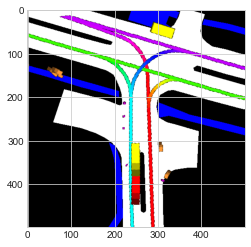

500 500 3


In [3]:
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

# Input representation
def GenerateImage(instance_token, sample_token):
    static_layer_rasterizer = StaticLayerRasterizer(helper)
    agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)

    mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    img = mtp_input_representation.make_input_representation(instance_token, sample_token)

    return img


target_instance_token, start_prediction_sample_token = test[29].split("_")

img = GenerateImage(target_instance_token, start_prediction_sample_token)
plt.imshow(img)
plt.show()

print(len(img), len(img[0]), len(img[0][0]))

In [4]:
import numpy as np
import torch

# NaN Values processing
def agent_param_processing(value):
    if np.isnan(value):
        return -1
    return value

vel = helper.get_velocity_for_agent(target_instance_token, start_prediction_sample_token)
vel = agent_param_processing(vel)

accel = helper.get_acceleration_for_agent(target_instance_token, start_prediction_sample_token)
accel = agent_param_processing(accel)

heading_cr = helper.get_heading_change_rate_for_agent(target_instance_token, start_prediction_sample_token)
heading_cr = agent_param_processing(heading_cr)

agent_state_vector = torch.Tensor([vel, accel, heading_cr])
agent_state_vector

tensor([ 2.4680, -0.6334,  0.0000])

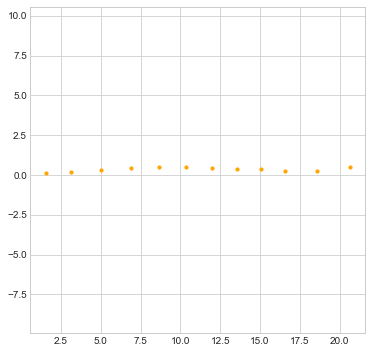

In [5]:
import matplotlib.pyplot as plt

def PlotPathWithPrediction(future, predict=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='orange', s=10)
    
    if len(predict) > 0:
        plt.scatter(predict[:, 1], -predict[:, 0], c='g', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()


gt = helper.get_future_for_agent(target_instance_token, start_prediction_sample_token, prediction_length, in_agent_frame=True)
    
PlotPathWithPrediction(gt)

Make cycle for small amout of data. Creating dataframe

In [6]:
import numpy as np
from enum import Enum

np.set_printoptions(threshold=500*500*3)

class DatasetColumns(Enum):
    FEATURES = 1
    STATES = 2
    LABELS = 3
    
# NaN Values processing
def agent_param_processing(value):
    if np.isnan(value):
        return -1
    return value

In [7]:
from tqdm import tqdm

NPY_DATAROOT = './NpyDataset/'


def ConvertSamplesToNpy(data, filename, dataToConvert):
    
    if dataToConvert == DatasetColumns.FEATURES:
        dataset_to_npy = np.empty([len(data), 500*500*3], dtype=np.uint8)
    
    if dataToConvert == DatasetColumns.STATES:
        dataset_to_npy = np.empty([len(data), 3])

    if dataToConvert == DatasetColumns.LABELS:
        dataset_to_npy = np.empty([len(data), 2*2*prediction_length])
    
    for i, x in enumerate(tqdm(dataset_to_npy)):
        instance_token, sample_token = data[i].split("_")
        
        if dataToConvert == DatasetColumns.FEATURES:
            # Take x
            img = GenerateImage(instance_token, sample_token)
            row = img.flatten()
            
        if dataToConvert == DatasetColumns.STATES:
            
            vel = helper.get_velocity_for_agent(instance_token, sample_token)
            vel = agent_param_processing(vel)

            accel = helper.get_acceleration_for_agent(instance_token, sample_token)
            accel = agent_param_processing(accel)

            heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
            heading_cr = agent_param_processing(heading_cr)
                
            row = np.array([vel, accel, heading_cr])
        
        if dataToConvert == DatasetColumns.LABELS:
            # Take y
            gt = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
            row = gt.flatten()
            
        dataset_to_npy[i] = row
        
    np.save(f"{NPY_DATAROOT}{filename}", dataset_to_npy)

Train

In [88]:
amount_of_rows = 12000

In [10]:
ConvertSamplesToNpy(train[5000:12000], 'data_features_5k-12k.npy', DatasetColumns.FEATURES)

100%|██████████| 7000/7000 [10:02:39<00:00,  5.17s/it]  


In [89]:
ConvertSamplesToNpy(train[:amount_of_rows], 'data_states_5000.npy', DatasetColumns.STATES)

100%|██████████| 5000/5000 [00:01<00:00, 2583.72it/s]


In [90]:
ConvertSamplesToNpy(train[:amount_of_rows], 'data_labels_5000.npy', DatasetColumns.LABELS)

100%|██████████| 5000/5000 [00:00<00:00, 10370.23it/s]


Validation

In [ ]:
amount_of_rows = 5000

In [8]:
ConvertSamplesToNpy(validation[2000:5000], 'data_validation_features_2k-5k.npy', DatasetColumns.FEATURES)

100%|██████████| 3000/3000 [4:04:49<00:00,  4.90s/it]   


In [9]:
ConvertSamplesToNpy(validation[:amount_of_rows], 'data_validation_states_2k-5k.npy', DatasetColumns.STATES)

100%|██████████| 3000/3000 [00:01<00:00, 2409.46it/s]


In [10]:
ConvertSamplesToNpy(validation[:amount_of_rows], 'data_validation_labels_2k-5k.npy', DatasetColumns.LABELS)

100%|██████████| 3000/3000 [00:00<00:00, 8412.59it/s]


Test

In [16]:
amount_of_rows = 5000

In [11]:
ConvertSamplesToNpy(test[500:5000], 'data_test_features_500-5k.npy', DatasetColumns.FEATURES)

100%|██████████| 4500/4500 [6:47:12<00:00,  5.43s/it]   


In [12]:
ConvertSamplesToNpy(test[:amount_of_rows], 'data_test_states_500-5k.npy', DatasetColumns.STATES)

100%|██████████| 4500/4500 [00:02<00:00, 2200.64it/s]


In [13]:
ConvertSamplesToNpy(test[:amount_of_rows], 'data_test_labels_500-5k.npy', DatasetColumns.LABELS)

100%|██████████| 4500/4500 [00:00<00:00, 7962.76it/s]


Try to read data and check

In [79]:
loaded_img = np.load(f'{NPY_DATAROOT}data_validation_features_30.npy')
loaded_states = np.load(f'{NPY_DATAROOT}data_validation_states_30.npy')
loaded_labels = np.load(f'{NPY_DATAROOT}data_validation_labels_30.npy')

index_to_check = 29

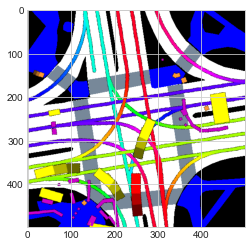

In [80]:
img = loaded_img[index_to_check]
img = img.reshape((500, 500, 3))

plt.imshow(img)
plt.show()

In [81]:
state = loaded_states[index_to_check]
state

array([ 5.15217246, -0.0822539 , -0.14822492])

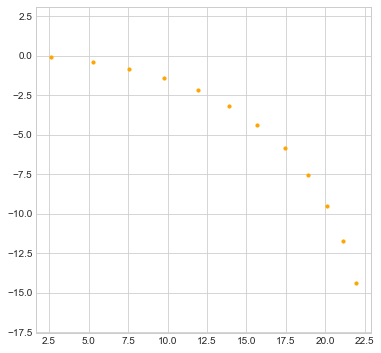

In [82]:
gt = loaded_labels[index_to_check]
gt = gt.reshape((12, 2))

PlotPathWithPrediction(gt)

### Try generate dataset with GPU acceleration

In [ ]:
import torch

print(torch.cuda.is_available())

device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on ', device)
print(f"Device count: {torch.cuda.device_count()}")

In [ ]:
from tqdm import tqdm

NPY_DATAROOT = './NpyDataset/'


def ConvertSamplesToNpyTensors(data, filename):
    
    dataset_to_npy = np.empty([len(data), 500*500*3], dtype=np.uint8)
    dataset_to_npy = torch.from_numpy(dataset_to_npy).to(device0)
    
    for i, x in enumerate(tqdm(dataset_to_npy)):
        instance_token, sample_token = data[i].split("_")
        
        # Take x
        img = GenerateImage(instance_token, sample_token)
        row = img.flatten()
        row = torch.tensor(row).to(device0)

        dataset_to_npy[i] = row
     
    torch.save(dataset_to_npy, f"{NPY_DATAROOT}{filename}")

In [32]:
loaded_tesnor = torch.load(f"{NPY_DATAROOT}{'img_tensor.pt'}")

In [34]:
loaded_tesnor.size()

torch.Size([2000, 750000])

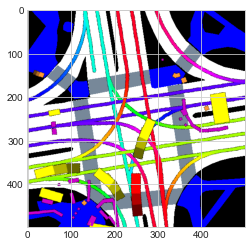

In [38]:
img = loaded_tesnor[29].reshape((500, 500, 3)).cpu().numpy()

plt.imshow(img)
plt.show()

Generate agent's tensors